# Twitter Sentiment Analysis

In [146]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import requests

## Dataset

In [147]:
# Import CSV
df_twt_raw = pd.read_csv('/home/manwar3/NLP/source/comments_data.csv',delimiter='|')

In [148]:
df_twt_raw.head()

,comments,label
0,"Sangat puas dengan layanan di sini, cepat dan ...",0
1,Suka bgt sama first media jaringan dan layanan...,0
2,"Jaringannya buruk sekali, sangat mengecewakan.",1
3,"Linknet bagus sekali, saya menikmati setiap me...",0
4,Pelayanan pelanggan mereka sangat lambat dan t...,1


In [149]:
df_twt_raw.groupby('label').describe()

comments                                                               
         count unique                                                top freq
label                                                                        
0          213    161  Layanan FirstMedia selalu memberikan yang terb...    4
1          200    200     Jaringannya buruk sekali, sangat mengecewakan.    1

# Exploratory Data Analysis

In [150]:
# Apply lambda len to add new df as length
df_twt_raw['length'] = df_twt_raw['comments'].apply(len)

In [151]:
df_twt_raw.head()

,comments,label,length
0,"Sangat puas dengan layanan di sini, cepat dan ...",0,55
1,Suka bgt sama first media jaringan dan layanan...,0,63
2,"Jaringannya buruk sekali, sangat mengecewakan.",1,46
3,"Linknet bagus sekali, saya menikmati setiap me...",0,53
4,Pelayanan pelanggan mereka sangat lambat dan t...,1,61


array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

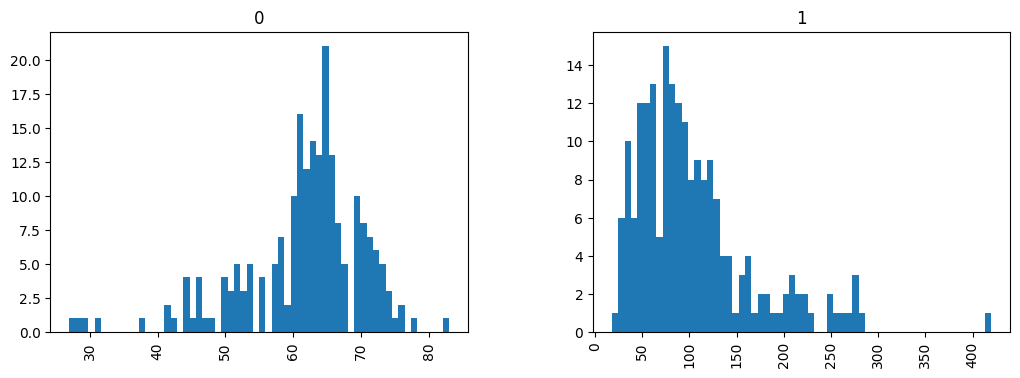

In [152]:
df_twt_raw.hist(column='length',by='label',bins=60,figsize=(12,4))

In [153]:
average_length_by_label = df_twt_raw.groupby('label')['length'].mean()
print(average_length_by_label)

label
0     61.666667
1    103.780000
Name: length, dtype: float64


we could analyzed that average message length of negative sentiment has longer message in compare by possitive sentiment message length.

### Calculate balance dataset

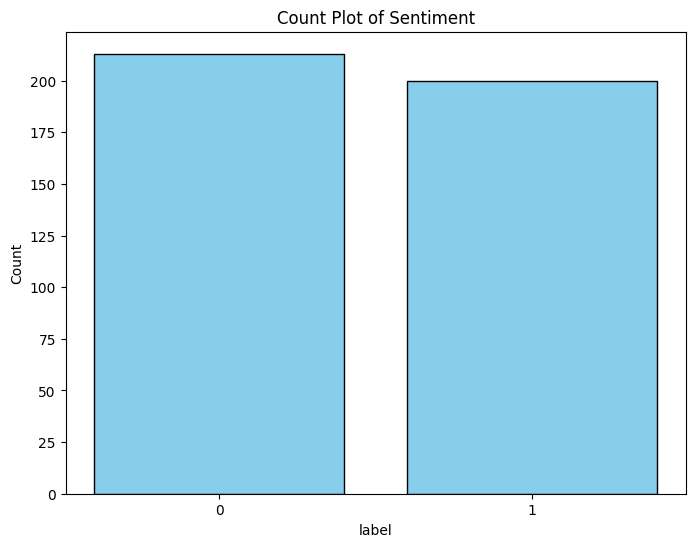

In [154]:
# Count the occurrences of each category
counts = df_twt_raw['label'].value_counts()

# Plot using Matplotlib
plt.figure(figsize=(8, 6))
plt.bar(counts.index.astype(str), counts.values, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('label')
plt.ylabel('Count')
plt.title('Count Plot of Sentiment')

# Show plot
plt.show()

## Prepare Training Data

In [155]:
from sklearn.model_selection import train_test_split

In [156]:
data_train,data_test,label_train,label_test = train_test_split(df_twt_raw['comments'],df_twt_raw['label'],test_size=0.3)

#### Check DataTrain.

In [157]:
data_train

341    Layanan pelanggan FirstMedia selalu cepat tang...
285    FirstMedia selalu memberikan promo menarik unt...
123    @FirstMediaCares min kok saya udh minta cabut ...
228    Kualitas suara dan gambar di TV kabel FirstMed...
314    Saya sangat senang dengan kualitas channel fil...
                             ...                        
30     @FirstMediaCares daerah tajur ciledug tangeran...
238     Teknisi FirstMedia sangat profesional dan ramah.
98     @FirstMediaCares kebiasaan banget tiap ujan la...
164    @FirstMediaCares lagi gangguan kah min? id : 1...
212    @FirstMediaCares ini wifi saya udah setengah h...
Name: comments, Length: 289, dtype: object

## Custom Preprocessing

Karena kita menggunakan bahasa indonesia, jadi diperlukan custom preprocessing yang mungkin berbeda dengan english based text process, Preprocess awal yaitu menghilangkan symbolic / karakter aneh didalam document seperti punctuation. normalisasi upper dan lower-casing. could be more added actually.

In [158]:
import re

# cleaning text
def cleaning_text(text):
    # remove url
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text =  url_pattern.sub(r'', text)

    # remove hashtags
    # only removing the hash # sign from the word
    text = re.sub(r'#', '', text)

    # remove mention handle user (@)
    text = re.sub(r'@[\w]*', ' ', text)

    # remove punctuation
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for x in text.lower():
        if x in punctuations:
            text = text.replace(x, " ")

    # remove extra whitespace
    text = text.strip()

    # lowercase
    text = text.lower()
    return text

## Set Custom Indonesian Stop Words, to remove unsignificant importance word in the sentence

Stop words adalah menghilangkan kata yang tidak secara signifikan berkorelasi dengan label, contoh kata dalam subject :saya, kamu, contoh seperti misalkan, padahal, dll.

In [159]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

# CONSTRUCT STOPWORDS
rama_stopword = "https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/stopword.txt"
yutomo_stopword = "https://raw.githubusercontent.com/yasirutomo/python-sentianalysis-id/master/data/feature_list/stopwordsID.txt"
fpmipa_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/fpmipa-stopwords.txt"
sastrawi_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/sastrawi-stopwords.txt"
aliakbar_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/aliakbars-bilp.txt"
pebahasa_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/pebbie-pebahasa.txt"
elang_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-id.txt"
nltk_stopword = stopwords.words('indonesian')

# create path url for each stopword
path_stopwords = [rama_stopword, yutomo_stopword, fpmipa_stopword, sastrawi_stopword,
                  aliakbar_stopword, pebahasa_stopword, elang_stopword]

# combine stopwords
stopwords_l = nltk_stopword
for path in path_stopwords:
    response = requests.get(path)
    stopwords_l += response.text.split('\n')

# Tambahin custom stop words, ke dokumen kita
custom_st = '''
yg yang dgn ane smpai bgt gua gwa si tu ama utk udh btw
ntar lol ttg emg aj aja tll sy sih kalo nya trsa mnrt nih
ma dr ajaa tp akan bs bikin kta pas pdahl bnyak guys abis tnx
bang banget nang mas amat bangettt tjoy hemm haha sllu hrs lanjut
bgtu sbnrnya trjadi bgtu pdhl sm plg skrg first media firstmedia firstmediacares 
linknet link net layan layanan pelayanan jaring jaringan jaringannya langgan langganan
min hallo halo id langgan pelanggan admin internet wifi wifinya semalem sangat
'''

# create dictionary with unique stopword
st_words = set(stopwords_l)
custom_stopword = set(custom_st.split())

# result stopwords 
stop_words = st_words | custom_stopword

# custom reverse word to remove
reverse_word = ['tidak', 'bukan', 'tak', 'belum', 'kurang', 'jangan', 'nggak', 'ga', 'gak', 'ndak', 'bukanlah']
stop_words = [elem for elem in stop_words if elem not in reverse_word]
print(f'Stopwords: {list(stop_words)[0:5]}')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/manwar3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/manwar3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Stopwords: ['tidakkah', 'lalu', 'inilah', 'pukul', 'seperlunya']


### Function to remove stopwords

In [160]:
from nltk import word_tokenize, sent_tokenize

def remove_stopword(text, stop_words=stop_words):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return ' '.join(filtered_sentence)

### Process Stemming.

In [161]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming_and_lemmatization(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(text)

### Process Tokenization

** Process tokenization adalah process split document menjadi beberapa list dictionary contoh :
"pelayanan firstmedia memuaskan" sehingga menjadi 
['pelayanan', 'firstmedia', 'memuaskan']


In [162]:
def tokenize(text):
    return word_tokenize(text)

### Sample Preprocessing Custom Text

Sample Process saat preprocessing,
1. Cleaning dari karakter-karakter aneh.
2. Menghilangkan Stopwords / Kata yang tidak penting / tidak signifikan membedakan positif/negatif
3. Stemming dan lemmatizing (mengambil kata dasar dari sebuah kata e.g mempedulikan - peduli, semalam - malam)
4. Tokenization (memisahkan setiap document menjadi dictonary list)

In [163]:
# example
text = 'Semalam nonton film ini, paginya ane download, malem langsung nonton.. ane smpai begadang.. hasilnya? Ane Kecewa... http://fb.me/13sZi5lbC'
print(f'Original text: \n{text}\n')

# cleaning text and lowercase
text = cleaning_text(text)
print(f'Cleaned text: \n{text}\n')

# remove stopwords
text = remove_stopword(text)
print(f'Removed stopword: \n{text}\n')

# stemming and lemmatization
text = stemming_and_lemmatization(text)
print(f'Stemmed and lemmatized: \n{text}\n')

# tokenization
text = tokenize(text)
print(f'Tokenized: \n{text}')

Original text: 
Semalam nonton film ini, paginya ane download, malem langsung nonton.. ane smpai begadang.. hasilnya? Ane Kecewa... http://fb.me/13sZi5lbC

Cleaned text: 
semalam nonton film ini  paginya ane download  malem langsung nonton   ane smpai begadang   hasilnya  ane kecewa

Removed stopword: 
semalam nonton film paginya download malem nonton begadang hasilnya kecewa

Stemmed and lemmatized: 
malam nonton film pagi download malem nonton begadang hasil kecewa

Tokenized: 
['malam', 'nonton', 'film', 'pagi', 'download', 'malem', 'nonton', 'begadang', 'hasil', 'kecewa']


## Pipeline for our Datasets.

Prepare step pipeline untuk memproses dataframe / mapping dataframe kedalam function

In [164]:
def preprocess(text):
    #print(f"Raw: {text} \n")  # Debugging output

    # cleaning text and lowercase
    output = cleaning_text(text)
    #print(f"Cleaned text: {output}")  # Debugging output
    
    # remove stopwords
    output = remove_stopword(output)
    #print(f"Text after stopword removal: {output}")
        
    # stemming and lemmatization
    output = stemming_and_lemmatization(output)
    #print(f"Text after stemming and lemmatization: {output} \n")
    # Tokenization dilakukan saat CountVectorizer() didalam Pipeline

    return output

In [165]:
from sklearn.base import BaseEstimator, TransformerMixin
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def transform(self, X, y=None):
        return [preprocess(text) for text in X]

    def fit(self, X, y=None):
        return self

## Train Pipeline

** Take a note as usual if we want to perform train and evaluate the model(text-based data) we need to repeat previous step such remove stop_words, punctuation, do Vectorization in this case CountVectorizer (bags_transformer) and do TFIDF to obatain weighted per word vs entire data, but instead we could use train pipeline that we don't need to repeat these process again.

In [166]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

** Tokenize Process done in CountVectorizer step

** Include kan function custom yang sudah dibuat

In [167]:
pipeline = Pipeline([
    ('preprocess', CustomPreprocessor()), # Custom Indonesian preprocess
    ('bow',CountVectorizer()), # Tokenize 
    ('tfidf',TfidfTransformer()), # TFIDF
    ('classifier',MultinomialNB()) # Classify
])

## Process Training Data.

In [168]:
pipeline.fit(data_train,label_train)

Pipeline(steps=[('preprocess', CustomPreprocessor()),
                ('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [169]:
pipe_predict = pipeline.predict(data_test)

In [170]:
from sklearn.metrics import classification_report

In [171]:
print(classification_report(label_test,pipe_predict))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98        67
           1       0.97      0.98      0.97        57

    accuracy                           0.98       124
   macro avg       0.98      0.98      0.98       124
weighted avg       0.98      0.98      0.98       124



Hasil Klasifikasi dari model akurasi cukup, bagus tetapi belum tentu mengeneralisir ketika bertemu real world case. mari kita coba.

# Custom Predictions

In [172]:
custom_text = [
    "firstmedia Internetnya sangat lambat",
    "saya merasa puas dengan pelayanan firstmedia",
    "Jaringan ga bagus",
    "Sangat puas dengan layanan firstmedia",
    "firstmedia jaringan nya bagus",
    "firstmedia jaringan nya sangat jelek"
]

In [173]:
custom_predictions = pipeline.predict(custom_text)

In [174]:
for text, prediction in zip(custom_text, custom_predictions):
    print(f"Text: {text}")
    print(f"Predicted Label: {prediction}")
    print()

Text: firstmedia Internetnya sangat lambat
Predicted Label: 1

Text: saya merasa puas dengan pelayanan firstmedia
Predicted Label: 0

Text: Jaringan ga bagus
Predicted Label: 1

Text: Sangat puas dengan layanan firstmedia
Predicted Label: 0

Text: firstmedia jaringan nya bagus
Predicted Label: 0

Text: firstmedia jaringan nya sangat jelek
Predicted Label: 1



** Dari custom testcase ada salah satu prediksi yang meleset, mungkin bisa ditambahkan dataset lagi untuk memperbaiki akurasi.

## Dump model

In [175]:
import joblib

In [176]:
joblib.dump(pipeline, 'sentiment_analysis_pipeline_twitter_LN.pkl')

['sentiment_analysis_pipeline_twitter_LN.pkl']